In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

import numpy as np
from multiprocess import Pool

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

%matplotlib inline

Setting environment for Precision WorkStation


No vtk
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
atlas_spec = dict(name='atlasV6',
                   vol_type='score'    ,               
                    resolution='10.0um'
                   )

In [3]:
atlas_structures_wrt_canonicalAtlasSpace_atlasResol = \
DataManager.load_original_volume_all_known_structures_v3(atlas_spec, in_bbox_wrt='canonicalAtlasSpace',
                                                        out_bbox_wrt='canonicalAtlasSpace')

Prior structure/index map not found. Generating a new one.


# Identify 3-d bounding box of each simpleGlobal aligned structure

In [15]:
# for stack in all_nissl_stacks:
for stack in ['MD661']:

    T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol = bp.unpack_ndarray_file('/home/yuncong/' + stack + '_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.bp')

    registered_atlas_structures_wrt_wholebrainWithMargin_atlasResol = \
    {name_s: transform_volume_v4(volume=vo, transform=T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol, return_origin_instead_of_bbox=True)
    for name_s, vo in atlas_structures_wrt_canonicalAtlasSpace_atlasResol.iteritems()}

    registered_atlas_structures_bbox_wrt_wholebrainWithMargin_atlasResol = \
    {name_s: (o[0], o[0] + v.shape[1] - 1, o[1], o[1] + v.shape[0] - 1, o[2], o[2] + v.shape[2] - 1)
     for name_s, (v, o) in registered_atlas_structures_wrt_wholebrainWithMargin_atlasResol.iteritems()}

    registered_atlas_structures_xyzTwoCorners_wrt_wholebrainWithMargin_atlasResol = \
    {name_s: ((o[0], o[2], o[4]), (o[1], o[3], o[5]))
    for name_s, o in registered_atlas_structures_bbox_wrt_wholebrainWithMargin_atlasResol.iteritems()}

    registered_atlas_structures_xyzCorners_wrt_wholebrainWithMargin_atlasResol = \
    {name_s: ((o[0], o[2], o[4]), (o[0], o[2], o[5]), (o[0], o[3], o[4]), (o[0], o[3], o[5]), \
             (o[1], o[2], o[4]), (o[1], o[2], o[5]), (o[1], o[3], o[4]), (o[1], o[3], o[5]))
    for name_s, o in registered_atlas_structures_bbox_wrt_wholebrainWithMargin_atlasResol.iteritems()}


    from data_manager import CoordinatesConverter

    converter = CoordinatesConverter(stack=stack)

    registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners = {}

    for name_s, corners_xyz in registered_atlas_structures_xyzTwoCorners_wrt_wholebrainWithMargin_atlasResol.iteritems():
    #     print name_s
        registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[name_s] = \
        converter.convert_frame_and_resolution(p=corners_xyz, 
                                           in_wrt=('wholebrainWithMargin', 'sagittal'),
                                          in_resolution='10.0um',
                                          out_wrt=('wholebrainXYcropped', 'sagittal'),
                                          out_resolution='image_image_section').astype(np.int)

    save_json(registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners, 
          '/home/yuncong/' + stack + '_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json')

/home/yuncong/Brain/utilities/registration_utilities.py:1567: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(volume_m_aligned_to_f.dtype, np.float):
Interpolating/filling sparse volume: 0.07 seconds.
Interpolating/filling sparse volume: 0.34 seconds.
Interpolating/filling sparse volume: 0.09 seconds.
Interpolating/filling sparse volume: 0.06 seconds.
Interpolating/filling sparse volume: 0.02 seconds.
Interpolating/filling sparse volume: 0.16 seconds.
Interpolating/filling sparse volume: 0.15 seconds.
Interpolating/filling sparse volume: 0.06 seconds.
Interpolating/filling sparse volume: 0.02 seconds.
Interpolating/filling sparse volume: 0.23 seconds.
Interpolating/filling sparse volume: 0.34 seconds.
Interpolating/filling sparse volume: 0.09 seconds.
Interpolating/filling sparse volume: 0.07 seconds.
Interpolating/filling sparse volume: 

In [4]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [5]:
# out_resolution_um = 10.
# out_resolution_str = '%.1fum' % out_resolution_um

# detector_id = 15 # For CSHL nissl data. e.g. MD593
# detector_id = 19 # For CSHL nissl data. e.g. MD589, denser window
detector_id = 799 # For UCSD neurotrace data, e.g. CHATM2, CHATM3

# print 'input_version:', detector_settings.loc[detector_id]['input_version']

In [6]:
# detector_setting = {}
# detector_setting['feature_classifier_id'] = 899
# detector_setting['windowing_id'] = 7

detector_setting = detector_settings.loc[detector_id]
clfs = DataManager.load_classifiers(classifier_id=detector_setting['feature_classifier_id'])
win_id = detector_setting['windowing_id']

In [8]:
# motor_nuclei = ['Amb', '3N', '4N', '5N', '6N', '7N', '10N', '12N']
# motor_nuclei = ['SNR', '7N', '5N', '7n', 'LRt', 'Sp5C', 'SNC', 'VLL', 'SC', 'IC']
motor_nuclei = ['Amb']

In [17]:
# for stack in ['CHATM2', 'CHATM3']:
# for stack in all_nissl_stacks:
for stack in ['MD661']:
    
    output_resolution = '10.0um'
    out_resolution_um = convert_resolution_string_to_um(resolution=output_resolution, stack=stack)
    
    valid_secmin = np.min(metadata_cache['valid_sections'][stack])
    valid_secmax = np.max(metadata_cache['valid_sections'][stack])
    
    ######## Do not use ROI ######

#     raw_w, raw_h = metadata_cache['image_shape'][stack]
    
#     registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection = defaultdict(dict)
    
#     for name_u in motor_nuclei:
#         for sec in range(valid_secmin, valid_secmax+1):  
#             if is_invalid(sec=sec, stack=stack):
#                 continue
            
#             registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection[name_u][sec] = (0,raw_w-1,0,raw_h-1)

    ######## Identify ROI based on simple global alignment ########

    registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners = \
load_json('/home/yuncong/' + stack + '_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json')

    
    registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection = defaultdict(dict)

#     section_margin_um = 1000.
    section_margin_um = 400.
    section_margin = int(section_margin_um / SECTION_THICKNESS)
    
    image_margin_um = 2000.
    image_margin = int(np.round(image_margin_um / convert_resolution_string_to_um('raw', stack)))

#     for name_u in ['7N']:
#     for name_u in all_known_structures:
    for name_u in motor_nuclei:
#     for name_u in ['RtTg', 'VCA', 'AP', 'Tz', 'LC', 'Sp5O', '7n', 'SNC', 'Sp5I', 'DC', 'Sp5C', 'VCP', 'RMC', 'PBG', 'SNR', 'LRt', 'SC', 'IC', 'Pn', 'VLL']:

        if name_u in singular_structures:

            (xmin, ymin, secmin), (xmax, ymax, secmax) = registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[name_u]

            for sec in range(max(secmin - section_margin, valid_secmin), min(secmax + 1 + section_margin, valid_secmax)):

                if is_invalid(sec=sec, stack=stack):
                    continue

                registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection[name_u][sec] = \
                (max(xmin - image_margin, 0), 
                 xmax + image_margin, 
                 max(ymin - image_margin, 0), 
                 ymax + image_margin)
        else:

            a = defaultdict(list)

            lname = convert_to_left_name(name_u)        
            (xmin, ymin, secmin), (xmax, ymax, secmax) = registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[lname]

            for sec in range(max(secmin - section_margin, valid_secmin), min(secmax + 1 + section_margin, valid_secmax)):

                if is_invalid(sec=sec, stack=stack):
                    continue

                a[sec].append((max(xmin - image_margin, 0), 
                 xmax + image_margin, 
                 max(ymin - image_margin, 0), 
                 ymax + image_margin))

            rname = convert_to_right_name(name_u)
            (xmin, ymin, secmin), (xmax, ymax, secmax) = registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[rname]

            for sec in range(max(secmin - section_margin, valid_secmin), min(secmax + 1 + section_margin, valid_secmax)):

                if is_invalid(sec=sec, stack=stack):
                    continue

                a[sec].append((max(xmin - image_margin, 0), 
                 xmax + image_margin, 
                 max(ymin - image_margin, 0), 
                 ymax + image_margin))

            for sec, bboxes in a.iteritems():
                if len(bboxes) == 1:
                    registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection[name_u][sec] = bboxes[0]
                else:
                    xmin, ymin = np.min(bboxes, axis=0)[[0,2]]
                    xmax, ymax = np.max(bboxes, axis=0)[[1,3]]
                    registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection[name_u][sec] = (xmin, xmax, ymin, ymax)
                    
    ######### Generate score maps ###########
                    
#     for name_u in all_known_structures:
    for name_u in motor_nuclei:
            
        for sec, bbox in sorted(registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection[name_u].items()):
            
    #         if is_invalid(sec=sec, stack=stack):
    #             continue
        
            print name_u, sec
        
            try:
                
                ############# Generate both scoremap and viz #################
                
                viz_all_landmarks, scoremap_all_landmarks = \
                draw_scoremap(clfs={name_u: clfs[name_u]}, 
                                      bbox=bbox,
                                scheme='none', 
                            win_id=win_id, prep_id=2,
                            stack=stack, 
                              return_what='both',
                              sec=sec,
                            model=model, model_name=model_name,
                             mean_img=mean_img, 
                             batch_size=batch_size,
                              output_patch_size=224,
                              is_nissl=False,
                           out_resolution_um=out_resolution_um,
                        image_shape=metadata_cache['image_shape'][stack],
                                      return_wholeimage=True)

                sm = scoremap_all_landmarks[name_u]
                viz = viz_all_landmarks[name_u]

                t = time.time()
                scoremap_bp_filepath = \
                DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec, 
                                                             structure=name_u,
                                                             detector_id=detector_id,
                                                             out_resolution_um=out_resolution_um)
                save_data(sm.astype(np.float16), scoremap_bp_filepath, upload_s3=False)
                sys.stderr.write('Save scoremap: %.2f seconds\n' % (time.time() - t))

                t = time.time()
                viz_filepath = \
                DataManager.get_scoremap_viz_filepath_v2(stack=stack, section=sec, 
                                                             structure=name_u,
                                                             detector_id=detector_id,
                                                             out_resolution=output_resolution)
                save_data(viz, viz_filepath, upload_s3=False)
                sys.stderr.write('Save scoremap viz: %.2f seconds\n' % (time.time() - t))
                
                del viz_all_landmarks, scoremap_all_landmarks
                
                ################ Generate scoremap only ################
        
#                 scoremap_all_landmarks = \
#                 draw_scoremap(clfs={name_u: clfs[name_u]}, 
#                                       bbox=bbox,
#                                 scheme='none', 
#                             win_id=win_id, prep_id=2,
#                             stack=stack, 
#                               return_what='scoremap',
#                               sec=sec,
#                             model=model, model_name=model_name,
#                              mean_img=mean_img, 
#                              batch_size=batch_size,
#                               output_patch_size=224,
#                               is_nissl=False,
#                            out_resolution_um=out_resolution_um,
#                         image_shape=metadata_cache['image_shape'][stack],
#                                       return_wholeimage=True)

#                 sm = scoremap_all_landmarks[name_u]

#                 scoremap_bp_filepath = \
#                 DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec, 
#                                                              structure=name_u,
#                                                              detector_id=detector_id,
#                                                              out_resolution_um=out_resolution_um)
#                 save_data(sm.astype(np.float16), scoremap_bp_filepath, upload_s3=False)

#                 del scoremap_all_landmarks
        
            except Exception as e:
                sys.stderr.write('%s\n' % e)
                continue
                
        
    ######### Generate score volumes ##########
        
# #     for name_u in all_known_structures:
#     for name_u in motor_nuclei:

        for name_s in [convert_to_left_name(name_u), convert_to_right_name(name_u)]:

            scoremaps = {}

    #         for sec in metadata_cache['valid_sections'][stack]:

            (xmin, ymin, s1), (xmax, ymax, s2) = registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[name_s]

            for sec in range(max(s1 - section_margin, metadata_cache['section_limits'][stack][0]), 
                             min(s2 + 1 + section_margin, metadata_cache['section_limits'][stack][1])):

                if is_invalid(sec=sec, stack=stack):
                    continue
                
                try:
                    scoremap = DataManager.load_downscaled_scoremap(stack=stack, section=sec, structure=name_u, 
                                                                    prep_id='alignedBrainstemCrop',
                                                                  out_resolution_um=out_resolution_um, 
                                                                    detector_id=detector_id).astype(np.float32)
                except Exception as e:
                    sys.stderr.write('%s\n' % e)
                    continue
                    
                mask = DataManager.load_image_v2(stack=stack, section=sec, 
                                     prep_id='alignedBrainstemCrop', 
                                     resol='thumbnail', version='mask')

                mask_outResol = rescale_by_resampling(mask, new_shape=(scoremap.shape[1], scoremap.shape[0]))

                scoremap[~mask_outResol] = 0
                scoremaps[sec] = scoremap
                
            t = time.time()

            volume_outVolResol, volume_origin_wrt_wholebrainXYcropped_outVolResol = \
            images_to_volume_v2(images=scoremaps, spacing_um=20.,
                                    in_resol_um=out_resolution_um,
                                    out_resol_um=out_resolution_um)
            print volume_outVolResol.shape
            sys.stderr.write('Images to volume: %.2f seconds\n' % (time.time() - t))

            brain_spec = dict(name=stack,
                           vol_type='score',
                            detector_id=detector_id,
                           resolution=output_resolution)

            # Save volume and origin.

            t = time.time()
            save_data(volume_outVolResol.astype(np.float16), \
                      DataManager.get_original_volume_filepath_v2(stack_spec=brain_spec, structure=name_s))

            wholebrainXYcropped_origin_wrt_wholebrain_outVolResol = \
            DataManager.get_domain_origin(stack=stack, domain='wholebrainXYcropped', 
                                          resolution=output_resolution)
            volume_origin_wrt_wholebrain_outVolResol =\
            volume_origin_wrt_wholebrainXYcropped_outVolResol + wholebrainXYcropped_origin_wrt_wholebrain_outVolResol

            save_data(volume_origin_wrt_wholebrain_outVolResol,
                      DataManager.get_original_volume_origin_filepath_v3(stack_spec=brain_spec, structure=name_s, wrt='wholebrain'))

            sys.stderr.write('Save score volume: %.2f seconds\n' % (time.time() - t))
            
            # Compute gradients.

            t = time.time()
            gradients = compute_gradient_v2((volume_outVolResol, volume_origin_wrt_wholebrain_outVolResol), 
                                            smooth_first=True)
            sys.stderr.write('Compute gradient: %.2f seconds\n' % (time.time() - t))

            t = time.time()
            DataManager.save_volume_gradients(gradients, stack_spec=brain_spec, structure=name_s)
            sys.stderr.write('Save gradient: %.2f seconds\n' % (time.time() - t))

Amb 109


locate patches: 0.03 seconds
Load pre-computed features: 0.55 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.71 seconds
Rescale background image to output resolution: 5.20 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 110


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.56 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.00 seconds
Rescale background image to output resolution: 6.63 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 111


Save scoremap viz: 0.05 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.56 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.65 seconds
Rescale background image to output resolution: 6.16 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 112


Save scoremap viz: 0.05 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.58 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.81 seconds
Rescale background image to output resolution: 6.57 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 113


Save scoremap viz: 0.06 seconds
locate patches: 0.04 seconds
Load pre-computed features: 0.57 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.71 seconds
Rescale background image to output resolution: 6.35 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 114


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.58 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.72 seconds
Rescale background image to output resolution: 4.94 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 115


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.73 seconds
Rescale background image to output resolution: 5.48 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 116


Save scoremap viz: 0.05 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.56 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.71 seconds
Rescale background image to output resolution: 4.87 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 117


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.84 seconds
Rescale background image to output resolution: 5.16 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 118


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.93 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.82 seconds
Rescale background image to output resolution: 5.84 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 119


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.89 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.75 seconds
Rescale background image to output resolution: 5.33 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)
Amb 120


Save scoremap: 0.01 seconds
Save scoremap viz: 0.08 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.64 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.82 seconds
Rescale background image to output resolution: 7.19 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 121


Save scoremap viz: 0.06 seconds
locate patches: 0.04 seconds
Load pre-computed features: 0.91 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.77 seconds
Rescale background image to output resolution: 5.29 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.22 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 122


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.57 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.77 seconds
Rescale background image to output resolution: 5.01 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 123


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.62 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.80 seconds
Rescale background image to output resolution: 5.88 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 124


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.96 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.74 seconds
Rescale background image to output resolution: 5.07 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.22 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds


(724, 1144, 3) (724, 1144)
Amb 125


Load pre-computed features: 0.96 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.76 seconds
Rescale background image to output resolution: 5.12 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 126


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.92 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.72 seconds
Rescale background image to output resolution: 5.16 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds


(724, 1144, 3) (724, 1144)
Amb 127


Load pre-computed features: 0.98 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.86 seconds
Rescale background image to output resolution: 5.22 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds


(724, 1144, 3) (724, 1144)
Amb 128


Load pre-computed features: 1.02 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.85 seconds
Rescale background image to output resolution: 6.15 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 129


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.86 seconds
Rescale background image to output resolution: 6.18 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 130


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.95 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.88 seconds
Rescale background image to output resolution: 8.40 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 131


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.00 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.83 seconds
Rescale background image to output resolution: 7.30 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 132


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.85 seconds
Rescale background image to output resolution: 7.91 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 133


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.61 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.91 seconds
Rescale background image to output resolution: 8.08 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 134


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.03 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.91 seconds
Rescale background image to output resolution: 4.76 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds


(724, 1144, 3) (724, 1144)
Amb 135


Load pre-computed features: 0.96 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 4.83 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds


(724, 1144, 3) (724, 1144)
Amb 136


Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.91 seconds
Rescale background image to output resolution: 4.85 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 137


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.23 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.93 seconds
Rescale background image to output resolution: 5.14 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 138


Save scoremap viz: 0.06 seconds
locate patches: 0.07 seconds
Load pre-computed features: 1.11 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.85 seconds
Rescale background image to output resolution: 6.62 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 139


Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.19 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.01 seconds
Rescale background image to output resolution: 5.40 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 140


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 5.08 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 141


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.05 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.93 seconds
Rescale background image to output resolution: 5.53 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 142


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F49-2017.06.06-00.05.38_MD661_1_0145_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.84 seconds
Rescale background image to output resolution: 5.08 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 143


Save scoremap viz: 0.06 seconds
locate patches: 0.13 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F49-2017.06.06-00.05.38_MD661_2_0146_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.79 seconds
Rescale background image to output resolution: 5.17 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds


(724, 1144, 3) (724, 1144)
Amb 144


Load pre-computed features: 1.02 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F49-2017.06.06-00.05.38_MD661_3_0147_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.82 seconds
Rescale background image to output resolution: 5.10 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 145


Save scoremap viz: 0.07 seconds
locate patches: 0.12 seconds
Load pre-computed features: 1.15 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.90 seconds
Rescale background image to output resolution: 4.78 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 146


Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.03 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F50-2017.06.06-00.35.44_MD661_2_0149_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.93 seconds
Rescale background image to output resolution: 4.81 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 147


Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.05 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F50-2017.06.06-00.35.44_MD661_3_0150_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.89 seconds
Rescale background image to output resolution: 4.67 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 148


Save scoremap viz: 0.07 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.11 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.97 seconds
Rescale background image to output resolution: 4.75 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 149


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F51-2017.06.06-01.06.07_MD661_2_0152_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.93 seconds
Rescale background image to output resolution: 4.80 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 150


Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.23 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F51-2017.06.06-01.06.07_MD661_3_0153_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.81 seconds
Rescale background image to output resolution: 4.90 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 151


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F52-2017.06.06-01.35.53_MD661_1_0154_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 5.14 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 152


Save scoremap viz: 0.06 seconds
locate patches: 0.09 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.01 seconds
Rescale background image to output resolution: 4.89 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 153


Save scoremap viz: 0.06 seconds
locate patches: 0.13 seconds
Load pre-computed features: 1.08 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.05 seconds
Rescale background image to output resolution: 5.08 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 154


Save scoremap viz: 0.05 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.05 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F53-2017.06.08-17.11.31_MD661_1_0157_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.91 seconds
Rescale background image to output resolution: 5.00 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 155


Save scoremap viz: 0.06 seconds
locate patches: 0.07 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.89 seconds
Rescale background image to output resolution: 5.04 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 156


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.64 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.84 seconds
Rescale background image to output resolution: 5.08 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 157


Save scoremap viz: 0.05 seconds
locate patches: 0.11 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F54-2017.06.22-17.00.44_MD661_1_0160_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 5.08 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 158


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.13 seconds
Rescale background image to output resolution: 5.17 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 159


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.06 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F54-2017.06.22-17.00.44_MD661_3_0162_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.10 seconds
Rescale background image to output resolution: 5.22 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.14 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 160


Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F55-2017.06.22-17.33.34_MD661_1_0163_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 5.74 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 161


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.96 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F55-2017.06.22-17.33.34_MD661_2_0164_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.16 seconds
Rescale background image to output resolution: 5.35 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.07 seconds


(724, 1144, 3) (724, 1144)
Amb 162


Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F55-2017.06.22-17.33.34_MD661_3_0165_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.07 seconds
Rescale background image to output resolution: 5.39 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 163


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 5.38 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 164


Save scoremap viz: 0.07 seconds
locate patches: 0.09 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 5.44 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 165


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.21 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.90 seconds
Rescale background image to output resolution: 5.39 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 166


Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F57-2017.06.06-02.06.22_MD661_1_0169_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.04 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 167


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F57-2017.06.06-02.06.22_MD661_2_0170_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.97 seconds
Rescale background image to output resolution: 6.23 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.26 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 168


Save scoremap viz: 0.06 seconds
locate patches: 0.12 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 5.62 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 169


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.08 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.04 seconds
Rescale background image to output resolution: 5.35 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 170


Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.38 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F58-2017.06.06-02.35.45_MD661_2_0173_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.92 seconds
Rescale background image to output resolution: 5.42 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 171


Save scoremap viz: 0.06 seconds
locate patches: 0.08 seconds
Load pre-computed features: 1.22 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F58-2017.06.06-02.35.45_MD661_3_0174_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.98 seconds
Rescale background image to output resolution: 5.69 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 172


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.22 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F59-2017.06.06-03.05.00_MD661_1_0175_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.12 seconds
Rescale background image to output resolution: 5.75 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 173


Save scoremap viz: 0.06 seconds
locate patches: 0.07 seconds
Load pre-computed features: 1.51 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F59-2017.06.06-03.05.00_MD661_2_0176_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.12 seconds
Rescale background image to output resolution: 5.78 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 174


Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.15 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.05 seconds
Rescale background image to output resolution: 5.82 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 175


Save scoremap viz: 0.07 seconds
locate patches: 0.07 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.00 seconds
Rescale background image to output resolution: 5.76 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 176


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F60-2017.06.06-03.35.37_MD661_2_0179_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.91 seconds
Rescale background image to output resolution: 5.47 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 177


Save scoremap viz: 0.06 seconds
locate patches: 0.09 seconds
Load pre-computed features: 1.13 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F60-2017.06.06-03.35.37_MD661_3_0180_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.12 seconds
Rescale background image to output resolution: 5.48 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 178


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F61-2017.06.06-04.06.02_MD661_1_0181_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 5.84 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 179


Save scoremap viz: 0.06 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.21 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.05 seconds
Rescale background image to output resolution: 5.77 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 180


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.39 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.09 seconds
Rescale background image to output resolution: 5.81 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 181


Save scoremap viz: 0.06 seconds
locate patches: 0.10 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F62-2017.06.06-04.35.55_MD661_1_0184_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.91 seconds
Rescale background image to output resolution: 5.50 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 182


Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.52 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F62-2017.06.06-04.35.55_MD661_2_0185_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.04 seconds
Rescale background image to output resolution: 5.96 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 183


Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.24 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F62-2017.06.06-04.35.55_MD661_3_0186_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.33 seconds
Rescale background image to output resolution: 5.87 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 184


Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F63-2017.06.06-05.05.24_MD661_1_0187_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.14 seconds
Rescale background image to output resolution: 5.73 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 185


Save scoremap viz: 0.06 seconds
locate patches: 0.12 seconds
Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.04 seconds
Rescale background image to output resolution: 6.08 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.14 seconds.
Generate scoremap overlay image Amb: 0.30 seconds


(724, 1144, 3) (724, 1144)
Amb 186


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.12 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F63-2017.06.06-05.05.24_MD661_3_0189_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.05 seconds
Rescale background image to output resolution: 4.81 seconds
Predict scores Amb: 0.05 seconds
Resample scoremap Amb: 0.16 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.13 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.32 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds


(724, 1144, 3) (724, 1144)
Amb 187


locate patches: 0.04 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F64-2017.06.06-05.35.10_MD661_1_0190_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.92 seconds
Rescale background image to output resolution: 4.62 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 188


Save scoremap viz: 0.08 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.26 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F64-2017.06.06-05.35.10_MD661_2_0191_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.32 seconds
Rescale background image to output resolution: 4.85 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 189


Save scoremap viz: 0.06 seconds
locate patches: 0.11 seconds
Load pre-computed features: 1.26 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F64-2017.06.06-05.35.10_MD661_3_0192_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 4.89 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 190


Save scoremap viz: 0.07 seconds
locate patches: 0.11 seconds
Load pre-computed features: 1.62 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.97 seconds
Rescale background image to output resolution: 5.21 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)
Amb 191


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.05 seconds
Rescale background image to output resolution: 4.81 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.14 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.13 seconds.
Scoremap size does not match background image size. Need to resize: 0.16 seconds.


(724, 1144, 3) (724, 1144)
Amb 192


Generate scoremap overlay image Amb: 0.35 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.10 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.25 seconds
Rescale background image to output resolution: 4.86 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.26 seconds


(724, 1144, 3) (724, 1144)
Amb 193


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.15 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F66-2017.06.06-06.35.52_MD661_1_0196_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 5.24 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)
Amb 194


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.45 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F66-2017.06.06-06.35.52_MD661_2_0197_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.22 seconds
Rescale background image to output resolution: 5.02 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.14 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.13 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.30 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 195


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.21 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.11 seconds
Rescale background image to output resolution: 4.58 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.15 seconds.


(724, 1144, 3) (724, 1144)
Amb 196


Generate scoremap overlay image Amb: 0.32 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.58 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F67-2017.06.06-07.07.27_MD661_1_0199_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.16 seconds
Rescale background image to output resolution: 4.47 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 197


Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.53 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.45 seconds
Rescale background image to output resolution: 4.44 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 198


Save scoremap viz: 0.06 seconds
locate patches: 0.11 seconds
Load pre-computed features: 1.21 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F67-2017.06.06-07.07.27_MD661_3_0201_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.18 seconds
Rescale background image to output resolution: 5.03 seconds
Predict scores Amb: 0.05 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 199


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F68-2017.06.06-07.39.27_MD661_1_0202_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 200


Save scoremap viz: 0.07 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.45 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F68-2017.06.06-07.39.27_MD661_2_0203_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.09 seconds
Rescale background image to output resolution: 4.78 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds


(724, 1144, 3) (724, 1144)
Amb 201


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.76 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F68-2017.06.06-07.39.27_MD661_3_0204_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 7.79 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 202


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.59 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F69-2017.06.06-08.11.04_MD661_1_0205_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 5.09 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 203


Save scoremap viz: 0.06 seconds
locate patches: 0.10 seconds
Load pre-computed features: 1.72 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.01 seconds
Rescale background image to output resolution: 4.49 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 204


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.52 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F70-2017.06.06-08.36.23_MD661_1_0208_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.02 seconds
Rescale background image to output resolution: 4.52 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 205


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.80 seconds
Rescale background image to output resolution: 4.46 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 206


Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.28 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.13 seconds
Rescale background image to output resolution: 4.48 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.26 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 207


Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.38 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F71-2017.06.06-09.00.35_MD661_2_0212_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.25 seconds
Rescale background image to output resolution: 5.03 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 208


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F72-2017.06.06-09.26.44_MD661_1_0214_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.14 seconds
Rescale background image to output resolution: 4.70 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds


(724, 1144, 3) (724, 1144)
Amb 209


locate patches: 0.06 seconds
Load pre-computed features: 1.41 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F72-2017.06.06-09.26.44_MD661_2_0215_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 7.16 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.14 seconds.
Generate scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)
Amb 210


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.08 seconds
Load pre-computed features: 1.39 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F73-2017.06.06-09.53.20_MD661_1_0217_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.28 seconds
Rescale background image to output resolution: 6.11 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 211


Save scoremap viz: 0.07 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.51 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F73-2017.06.06-09.53.20_MD661_2_0218_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.13 seconds
Rescale background image to output resolution: 4.42 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 212


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.51 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 5.42 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 213


Save scoremap viz: 0.08 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.60 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.06 seconds
Rescale background image to output resolution: 5.05 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 214


Save scoremap viz: 0.07 seconds
locate patches: 0.10 seconds
Load pre-computed features: 1.56 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.29 seconds
Rescale background image to output resolution: 5.03 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 215


Save scoremap viz: 0.06 seconds
locate patches: 0.08 seconds
Load pre-computed features: 1.43 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.95 seconds
Rescale background image to output resolution: 4.94 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 216


Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.35 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.02 seconds
Rescale background image to output resolution: 5.79 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 233


Save scoremap viz: 0.07 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.66 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F85-2017.06.06-14.30.01_MD661_2_0254_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.12 seconds
Rescale background image to output resolution: 5.64 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 234


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F86-2017.06.06-14.56.48_MD661_1_0256_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 7.09 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.26 seconds


(724, 1144, 3) (724, 1144)
Amb 235


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.95 seconds
Rescale background image to output resolution: 6.09 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 236


Save scoremap viz: 0.06 seconds
locate patches: 0.11 seconds
Load pre-computed features: 1.70 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.72 seconds
Rescale background image to output resolution: 5.71 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 237


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F87-2017.06.06-15.22.59_MD661_2_0260_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.30 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 238


Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F88-2017.06.06-15.57.25_MD661_1_0262_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.39 seconds
Rescale background image to output resolution: 5.87 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 239


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F88-2017.06.06-15.57.25_MD661_2_0263_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.02 seconds
Rescale background image to output resolution: 7.70 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 240


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.65 seconds
Rescale background image to output resolution: 5.78 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 241


Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.46 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.97 seconds
Rescale background image to output resolution: 5.34 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 242


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.10 seconds
Rescale background image to output resolution: 5.59 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 243


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.22 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F90-2017.06.06-17.16.08_MD661_2_0269_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 6.18 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 244


Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.59 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F91-2017.06.06-17.42.59_MD661_1_0271_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.29 seconds
Rescale background image to output resolution: 6.07 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 245


Save scoremap viz: 0.07 seconds
locate patches: 0.10 seconds
Load pre-computed features: 1.50 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.98 seconds
Rescale background image to output resolution: 6.56 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 246


Save scoremap viz: 0.06 seconds
locate patches: 0.12 seconds
Load pre-computed features: 1.66 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.20 seconds
Rescale background image to output resolution: 4.47 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 247


Save scoremap viz: 0.06 seconds
locate patches: 0.13 seconds
Load pre-computed features: 1.45 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F92-2017.06.06-18.08.17_MD661_2_0275_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.87 seconds
Rescale background image to output resolution: 4.48 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 248


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.72 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F93-2017.06.06-18.34.27_MD661_1_0277_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.18 seconds
Rescale background image to output resolution: 4.45 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 249


Save scoremap viz: 0.06 seconds
locate patches: 0.13 seconds
Load pre-computed features: 1.60 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F93-2017.06.06-18.34.27_MD661_2_0278_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.94 seconds
Rescale background image to output resolution: 4.43 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 250


Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F94-2017.06.06-19.01.05_MD661_1_0280_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 4.71 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 251


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.44 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.95 seconds
Rescale background image to output resolution: 4.42 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 252


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F95-2017.06.06-19.27.57_MD661_1_0283_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.00 seconds
Rescale background image to output resolution: 4.40 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 253


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F95-2017.06.06-19.27.57_MD661_2_0284_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.22 seconds
Rescale background image to output resolution: 4.65 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 254


Save scoremap viz: 0.06 seconds
locate patches: 0.10 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F96-2017.06.06-19.55.10_MD661_1_0286_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.05 seconds
Rescale background image to output resolution: 4.45 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 255


Save scoremap viz: 0.06 seconds
locate patches: 0.08 seconds
Load pre-computed features: 1.47 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.95 seconds
Rescale background image to output resolution: 4.39 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 256


Save scoremap viz: 0.06 seconds
locate patches: 0.13 seconds
Load pre-computed features: 1.67 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.07 seconds
Rescale background image to output resolution: 4.36 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 257


Save scoremap viz: 0.07 seconds
locate patches: 0.11 seconds
Load pre-computed features: 1.74 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F97-2017.06.06-20.20.43_MD661_2_0290_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.04 seconds
Rescale background image to output resolution: 4.47 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 258


Save scoremap viz: 0.07 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.54 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 4.76 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 259


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.41 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F98-2017.06.06-20.47.32_MD661_2_0293_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.92 seconds
Rescale background image to output resolution: 4.80 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 260


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.26 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F99-2017.06.06-21.14.03_MD661_1_0295_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 4.81 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 261


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.38 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F99-2017.06.06-21.14.03_MD661_2_0296_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 4.45 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 262


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F100-2017.06.06-21.40.10_MD661_1_0298_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.05 seconds
Rescale background image to output resolution: 4.34 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 263


Save scoremap viz: 0.06 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.61 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.92 seconds
Rescale background image to output resolution: 4.33 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 264


Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.54 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F101-2017.06.06-22.05.45_MD661_1_0301_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 4.44 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 265


Save scoremap viz: 0.06 seconds
locate patches: 0.07 seconds
Load pre-computed features: 1.49 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.91 seconds
Rescale background image to output resolution: 4.45 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 266


Save scoremap viz: 0.06 seconds
locate patches: 0.08 seconds
Load pre-computed features: 1.41 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.90 seconds
Rescale background image to output resolution: 4.50 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 267


Save scoremap viz: 0.08 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.26 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.85 seconds
Rescale background image to output resolution: 4.58 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 268


Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.94 seconds
Rescale background image to output resolution: 4.62 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 269


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F103-2017.06.06-22.56.22_MD661_2_0308_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.91 seconds
Rescale background image to output resolution: 4.80 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 270


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.26 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 4.84 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 271


Save scoremap viz: 0.07 seconds
locate patches: 0.07 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F104-2017.06.06-23.26.43_MD661_2_0311_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.90 seconds
Rescale background image to output resolution: 5.28 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 272


Save scoremap viz: 0.06 seconds
locate patches: 0.07 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F105-2017.06.06-23.53.33_MD661_1_0313_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.98 seconds
Rescale background image to output resolution: 5.53 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)
Amb 273


Save scoremap: 0.01 seconds
Save scoremap viz: 0.08 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.41 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.04 seconds
Rescale background image to output resolution: 7.16 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 274


Save scoremap viz: 0.06 seconds
locate patches: 0.09 seconds
Load pre-computed features: 1.52 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F106-2017.06.07-00.20.03_MD661_1_0316_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.99 seconds
Rescale background image to output resolution: 4.99 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 275


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.78 seconds
Rescale background image to output resolution: 5.01 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds


(724, 1144, 3) (724, 1144)
Amb 276


Load pre-computed features: 1.40 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F107-2017.06.07-00.44.42_MD661_1_0319_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.05 seconds
Rescale background image to output resolution: 5.07 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 277


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F107-2017.06.07-00.44.42_MD661_2_0320_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.93 seconds
Rescale background image to output resolution: 5.52 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 278


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F108-2017.06.07-01.10.56_MD661_1_0322_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.98 seconds
Rescale background image to output resolution: 5.24 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 279


Save scoremap viz: 0.07 seconds
locate patches: 0.13 seconds
Load pre-computed features: 1.41 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F108-2017.06.07-01.10.56_MD661_2_0323_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.95 seconds
Rescale background image to output resolution: 5.23 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 280


Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.44 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F109-2017.06.07-01.37.37_MD661_1_0325_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 5.22 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 281


Save scoremap viz: 0.07 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F109-2017.06.07-01.37.37_MD661_2_0326_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.91 seconds
Rescale background image to output resolution: 7.42 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 282


Save scoremap viz: 0.06 seconds
locate patches: 0.07 seconds
Load pre-computed features: 1.55 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F110-2017.06.07-02.03.05_MD661_1_0328_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.10 seconds
Rescale background image to output resolution: 5.30 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 283


Save scoremap viz: 0.06 seconds
locate patches: 0.13 seconds
Load pre-computed features: 1.59 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F110-2017.06.07-02.03.05_MD661_2_0329_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.97 seconds
Rescale background image to output resolution: 5.32 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 284


Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.38 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F111-2017.06.07-02.28.23_MD661_1_0331_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.89 seconds
Rescale background image to output resolution: 6.27 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 285


Save scoremap viz: 0.06 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.02 seconds
Rescale background image to output resolution: 6.36 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.14 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 286


Save scoremap viz: 0.07 seconds
locate patches: 0.12 seconds
Load pre-computed features: 1.50 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F112-2017.06.07-02.53.08_MD661_1_0334_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.82 seconds
Rescale background image to output resolution: 6.41 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 287


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.22 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F112-2017.06.07-02.53.08_MD661_2_0335_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.81 seconds
Rescale background image to output resolution: 4.53 seconds
Predict scores Amb: 0.06 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.14 seconds.
Generate scoremap overlay image Amb: 0.30 seconds


(724, 1144, 3) (724, 1144)
Amb 288


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 5.59 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.16 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.32 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds


(724, 1144, 3) (724, 1144)
Amb 289


locate patches: 0.03 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F113-2017.06.07-03.19.59_MD661_2_0338_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.01 seconds
Rescale background image to output resolution: 5.39 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.27 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 290


Save scoremap viz: 0.06 seconds
locate patches: 0.12 seconds
Load pre-computed features: 1.22 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F114-2017.06.07-03.45.47_MD661_1_0340_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.10 seconds
Rescale background image to output resolution: 6.30 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.16 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.31 seconds


(724, 1144, 3) (724, 1144)
Amb 291


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.08 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F114-2017.06.07-03.45.47_MD661_2_0341_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.78 seconds
Rescale background image to output resolution: 5.70 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 292


Save scoremap viz: 0.07 seconds
locate patches: 0.13 seconds
Load pre-computed features: 1.23 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.08 seconds
Rescale background image to output resolution: 5.71 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 293


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.15 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F115-2017.06.07-04.11.41_MD661_2_0344_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.79 seconds
Rescale background image to output resolution: 5.52 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 294


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.07 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.86 seconds
Rescale background image to output resolution: 5.54 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 295


Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.28 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.81 seconds
Rescale background image to output resolution: 5.52 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 296


Save scoremap viz: 0.06 seconds
locate patches: 0.09 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F118-2017.06.07-11.26.45_MD661_1_0352_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.21 seconds
Rescale background image to output resolution: 5.55 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 297


Save scoremap viz: 0.05 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.02 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F118-2017.06.07-11.26.45_MD661_2_0353_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.00 seconds
Rescale background image to output resolution: 5.46 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 298


Save scoremap viz: 0.05 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F117-2017.06.07-05.06.52_MD661_1_0349_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.40 seconds
Rescale background image to output resolution: 5.59 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 299


Save scoremap viz: 0.06 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F117-2017.06.07-05.06.52_MD661_2_0350_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.86 seconds
Rescale background image to output resolution: 5.62 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 300


Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.13 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F119-2017.06.07-11.50.55_MD661_1_0355_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 6.82 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 301


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F119-2017.06.07-11.50.55_MD661_2_0356_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.20 seconds
Rescale background image to output resolution: 5.57 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 302


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.10 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F120-2017.06.07-14.31.54_MD661_1_0358_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.09 seconds
Rescale background image to output resolution: 5.15 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 303


Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F120-2017.06.07-14.31.54_MD661_2_0359_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.85 seconds
Rescale background image to output resolution: 5.51 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)
Amb 304


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.08 seconds
Load pre-computed features: 1.15 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F121-2017.06.07-14.55.33_MD661_1_0361_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.84 seconds
Rescale background image to output resolution: 5.30 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)
Amb 305


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.86 seconds
Rescale background image to output resolution: 5.45 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 306


Save scoremap viz: 0.08 seconds
locate patches: 0.07 seconds
Load pre-computed features: 1.04 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F122-2017.06.07-15.19.59_MD661_1_0364_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.88 seconds
Rescale background image to output resolution: 5.87 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)
Amb 307


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.13 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.84 seconds
Rescale background image to output resolution: 6.62 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.14 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.


(724, 1144, 3) (724, 1144)
Amb 308


Generate scoremap overlay image Amb: 0.30 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.02 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F123-2017.06.07-16.02.16_MD661_1_0367_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.83 seconds
Rescale background image to output resolution: 5.65 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.26 seconds


(724, 1144, 3) (724, 1144)
Amb 309


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.04 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F123-2017.06.07-16.02.16_MD661_2_0368_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.93 seconds
Rescale background image to output resolution: 6.36 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)
Amb 310


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F124-2017.06.07-16.26.31_MD661_1_0370_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.80 seconds
Rescale background image to output resolution: 5.33 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.14 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.26 seconds


(724, 1144, 3) (724, 1144)
Amb 311


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.95 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F124-2017.06.07-16.26.31_MD661_2_0371_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.77 seconds
Rescale background image to output resolution: 5.67 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)
Amb 312


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.95 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.93 seconds
Rescale background image to output resolution: 6.22 seconds
Predict scores Amb: 0.04 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.27 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 313


Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F126-2017.06.07-17.13.02_MD661_2_0377_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.84 seconds
Rescale background image to output resolution: 5.49 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 314


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.00 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F125-2017.06.07-16.50.51_MD661_1_0373_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.86 seconds
Rescale background image to output resolution: 5.52 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 315


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.10 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.07 seconds
Rescale background image to output resolution: 6.16 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.14 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 316


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.93 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F127-2017.06.07-17.34.51_MD661_1_0379_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 5.39 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 317


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.93 seconds
Rescale background image to output resolution: 5.84 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 318


Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.93 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 5.67 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 319


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.90 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.77 seconds
Rescale background image to output resolution: 6.30 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.26 seconds


(724, 1144, 3) (724, 1144)
Amb 320


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.12 seconds
Load pre-computed features: 1.22 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F128-2017.06.07-18.06.20_MD661_2_0383_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.94 seconds
Rescale background image to output resolution: 5.70 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 321


Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.11 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F128-2017.06.07-18.06.20_MD661_3_0384_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.78 seconds
Rescale background image to output resolution: 5.94 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)
Amb 322


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.91 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F129-2017.06.07-18.36.41_MD661_1_0385_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.88 seconds
Rescale background image to output resolution: 4.97 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.26 seconds


(724, 1144, 3) (724, 1144)
Amb 323


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F129-2017.06.07-18.36.41_MD661_2_0386_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.82 seconds
Rescale background image to output resolution: 5.76 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.14 seconds.
Generate scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)
Amb 324


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.04 seconds
Load pre-computed features: 0.91 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F129-2017.06.07-18.36.41_MD661_3_0387_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.77 seconds
Rescale background image to output resolution: 6.50 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)
Amb 325


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.07 seconds
Load pre-computed features: 1.03 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.85 seconds
Rescale background image to output resolution: 5.47 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.14 seconds.
Generate scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)
Amb 326


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.86 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F130-2017.06.07-19.06.02_MD661_2_0389_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.82 seconds
Rescale background image to output resolution: 4.87 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds


(724, 1144, 3) (724, 1144)
Amb 327


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.90 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F130-2017.06.07-19.06.02_MD661_3_0390_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.16 seconds
Rescale background image to output resolution: 4.88 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.23 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 328


Save scoremap viz: 0.07 seconds
locate patches: 0.12 seconds
Load pre-computed features: 1.10 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F131-2017.06.07-19.36.32_MD661_1_0391_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.00 seconds
Rescale background image to output resolution: 5.38 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 329


Save scoremap viz: 0.06 seconds
locate patches: 0.04 seconds
Load pre-computed features: 0.88 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F131-2017.06.07-19.36.32_MD661_2_0392_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.83 seconds
Rescale background image to output resolution: 6.35 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.26 seconds


(724, 1144, 3) (724, 1144)
Amb 330


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 1.13 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.74 seconds
Rescale background image to output resolution: 6.28 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.13 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.31 seconds


(724, 1144, 3) (724, 1144)
Amb 331


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.83 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F132-2017.06.07-20.06.12_MD661_1_0394_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.81 seconds
Rescale background image to output resolution: 6.08 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.13 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.14 seconds.
Generate scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)
Amb 332


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.12 seconds
Load pre-computed features: 0.94 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F132-2017.06.07-20.06.12_MD661_2_0395_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.93 seconds
Rescale background image to output resolution: 5.29 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.15 seconds.
Scoremap size does not match background image size. Need to resize: 0.14 seconds.
Generate scoremap overlay image Amb: 0.34 seconds


(724, 1144, 3) (724, 1144)
Amb 333


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
locate patches: 0.04 seconds
Load pre-computed features: 0.84 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F132-2017.06.07-20.06.12_MD661_3_0396_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.81 seconds
Rescale background image to output resolution: 5.80 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.26 seconds


(724, 1144, 3) (724, 1144)
Amb 334


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.11 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F133-2017.06.07-20.35.00_MD661_1_0397_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.76 seconds
Rescale background image to output resolution: 5.58 seconds
Predict scores Amb: 0.02 seconds
Resample scoremap Amb: 0.15 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds


(724, 1144, 3) (724, 1144)
Amb 335


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.04 seconds
Load pre-computed features: 0.81 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.84 seconds
Rescale background image to output resolution: 5.43 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.25 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
Amb 336


Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 1.00 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F133-2017.06.07-20.35.00_MD661_3_0399_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.68 seconds
Rescale background image to output resolution: 7.83 seconds
Predict scores Amb: 0.03 seconds
Resample scoremap Amb: 0.14 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)
Amb 337


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.06 seconds
Load pre-computed features: 0.95 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F134-2017.06.07-21.04.24_MD661_1_0400_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.77 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores Amb: 0.01 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image Amb: 0.25 seconds


(724, 1144, 3) (724, 1144)
Amb 338


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.92 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F134-2017.06.07-21.04.24_MD661_2_0401_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.76 seconds
Rescale background image to output resolution: 5.38 seconds
Predict scores Amb: 0.00 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)
Amb 339


Save scoremap: 0.01 seconds
Save scoremap viz: 0.05 seconds
locate patches: 0.03 seconds
Load pre-computed features: 0.81 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F134-2017.06.07-21.04.24_MD661_3_0402_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.93 seconds
Rescale background image to output resolution: 5.39 seconds
Predict scores Amb: 0.00 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.25 seconds


(724, 1144, 3) (724, 1144)
Amb 340


Save scoremap: 0.01 seconds
Save scoremap viz: 0.05 seconds
locate patches: 0.10 seconds
Load pre-computed features: 0.86 seconds
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F135-2017.06.07-21.33.10_MD661_1_0403_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.71 seconds
Rescale background image to output resolution: 5.40 seconds
Predict scores Amb: 0.00 seconds
Resample scoremap Amb: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image Amb: 0.24 seconds
Save scoremap: 0.01 seconds


(724, 1144, 3) (724, 1144)
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_thumbnail_mask.png


Save scoremap viz: 0.07 seconds
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F41-2017.06.05

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F44-2017.06.05

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F47-2017.06.05

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD661_1_0145_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD661_2_0146_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD661_3_0147_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F50-2017.06.06

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD661_2_0152_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD661_3_0153_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD661_1_0154_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD661_1_0157_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F53-2017.06.08

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD661_3_0162_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD661_1_0163_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD661_2_0164_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD661_3_0165_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F56-2017.06.08

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD661_2_0173_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD661_3_0174_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD661_1_0175_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD661_2_0176_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F60-2017.06.06

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD661_1_0181_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD661_1_0184_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD661_2_0185_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD661_3_0186_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD661_1_0187_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F63-2017.06.06

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD661_2_0191_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD661_3_0192_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD661_1_0196_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD661_2_0197_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F66-2017.06.06

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD661_3_0201_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD661_1_0202_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD661_2_0203_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD661_3_0204_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F69-2017.06.06-08.11.04_MD661_1_0205_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F70-2017.06.06-08.36.23_MD661_1_0208_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F70-2017.06.06

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F72-2017.06.06-09.26.44_MD661_2_0215_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F73-2017.06.06-09.53.20_MD661_1_0217_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F73-2017.06.06-09.53.20_MD661_2_0218_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F77-2017.06.06

Images to volume: 9.73 seconds
aws s3 cp "/home/yuncong/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volumes/MD661_detector799_10.0um_scoreVolume_Amb_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volumes/MD661_detector799_10.0um_scoreVolume_Amb_L.bp"
return code: 0
aws s3 cp "/home/yuncong/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volumes/MD661_detector799_10.0um_scoreVolume_Amb_L_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volumes/MD661_detector799_10.0um_scoreVolume_Amb_L_origin_wrt_wholebrain.txt"


loaded_cropbox_resolution down32


return code: 0
Save score volume: 2.67 seconds
Compute gradient: 3.98 seconds
aws s3 cp "/home/yuncong/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volume_gradients/MD661_detector799_10.0um_scoreVolume_Amb_L_gradients.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volume_gradients/MD661_detector799_10.0um_scoreVolume_Amb_L_gradients.bp"
return code: 0
aws s3 cp "/home/yuncong/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volume_gradients/MD661_detector799_10.0um_scoreVolume_Amb_L_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volume_gradients/MD661_detector799_10.0um_scoreVolume_Amb_L_origin_wrt_wholebrain.txt"
return code: 0
Save gradient: 2.61 seconds
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not us

/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F85-2017.06.06-14.30.01_MD661_2_0254_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F86-2017.06.06-14.56.48_MD661_1_0256_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F87-2017.06.06-15.22.59_MD661_2_0260_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F88-2017.06.06-15.57.25_MD661_1_0262_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F88-2017.06.06-15.57.25_MD661_2_0263_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F89-2017.06.06

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F90-2017.06.06-17.16.08_MD661_2_0269_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F91-2017.06.06-17.42.59_MD661_1_0271_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F92-2017.06.06-18.08.17_MD661_2_0275_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F93-2017.06.06-18.34.27_MD661_1_0277_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F93-2017.06.06-18.34.27_MD661_2_0278_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F94-2017.06.06

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F95-2017.06.06-19.27.57_MD661_2_0284_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F96-2017.06.06-19.55.10_MD661_1_0286_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F97-2017.06.06-20.20.43_MD661_2_0290_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F98-2017.06.06-20.47.32_MD661_2_0293_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F99-2017.06.06

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F101-2017.06.06-22.05.45_MD661_1_0301_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F103-2017.06.06-22.56.22_MD661_2_0308_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F104-20

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F106-2017.06.07-00.20.03_MD661_1_0316_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F107-2017.06.07-00.44.42_MD661_1_0319_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F107-2017.06.07-00.44.42_MD661_2_0320_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F108-2017.06.07-01.10.56_MD661_1_0322_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F108-2017.06.07-01.10.56_MD661_2_0323_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F109-20

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F110-2017.06.07-02.03.05_MD661_2_0329_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F111-2017.06.07-02.28.23_MD661_1_0331_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F112-2017.06.07-02.53.08_MD661_1_0334_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F112-2017.06.07-02.53.08_MD661_2_0335_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F113-2017.06.07-03.19.59_MD661_2_0338_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F114-20

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F118-2017.06.07-11.26.45_MD661_1_0352_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F118-2017.06.07-11.26.45_MD661_2_0353_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F117-2017.06.07-05.06.52_MD661_1_0349_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F117-2017.06.07-05.06.52_MD661_2_0350_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F119-2017.06.07-11.50.55_MD661_1_0355_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F119-20

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F122-2017.06.07-15.19.59_MD661_1_0364_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F123-2017.06.07-16.02.16_MD661_1_0367_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F123-2017.06.07-16.02.16_MD661_2_0368_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F124-2017.06.07-16.26.31_MD661_1_0370_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F124-2017.06.07-16.26.31_MD661_2_0371_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F126-20

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD661_1_0379_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD661_2_0383_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD661_3_0384_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F129-20

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD661_2_0389_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD661_3_0390_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD661_1_0391_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD661_2_0392_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD661_1_0394_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F132-20

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD661_3_0399_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD661_1_0400_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD661_2_0401_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD661_3_0402_prep2_thumbnail_mask.png
/data/CSHL_data_processed/MD661/MD661_prep2_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD661_1_0403_prep2_thumbnail_mask.png
(299, 479, 217)


Images to volume: 12.57 seconds
aws s3 cp "/home/yuncong/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volumes/MD661_detector799_10.0um_scoreVolume_Amb_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volumes/MD661_detector799_10.0um_scoreVolume_Amb_R.bp"
return code: 0
aws s3 cp "/home/yuncong/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volumes/MD661_detector799_10.0um_scoreVolume_Amb_R_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volumes/MD661_detector799_10.0um_scoreVolume_Amb_R_origin_wrt_wholebrain.txt"


loaded_cropbox_resolution down32


return code: 0
Save score volume: 2.65 seconds
Compute gradient: 4.46 seconds
aws s3 cp "/home/yuncong/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volume_gradients/MD661_detector799_10.0um_scoreVolume_Amb_R_gradients.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volume_gradients/MD661_detector799_10.0um_scoreVolume_Amb_R_gradients.bp"
return code: 0
aws s3 cp "/home/yuncong/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volume_gradients/MD661_detector799_10.0um_scoreVolume_Amb_R_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD661/MD661_detector799_10.0um_scoreVolume/score_volume_gradients/MD661_detector799_10.0um_scoreVolume_Amb_R_origin_wrt_wholebrain.txt"
return code: 0
Save gradient: 3.90 seconds


# Check

In [26]:
img = DataManager.load_image_v2(stack='CHATM2', resol='raw', 
                                version='NtbNormalizedAdaptiveInvertedGammaJpeg',
                                        prep_id=2, section=201)

Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM2_slide66_2018_02_14-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


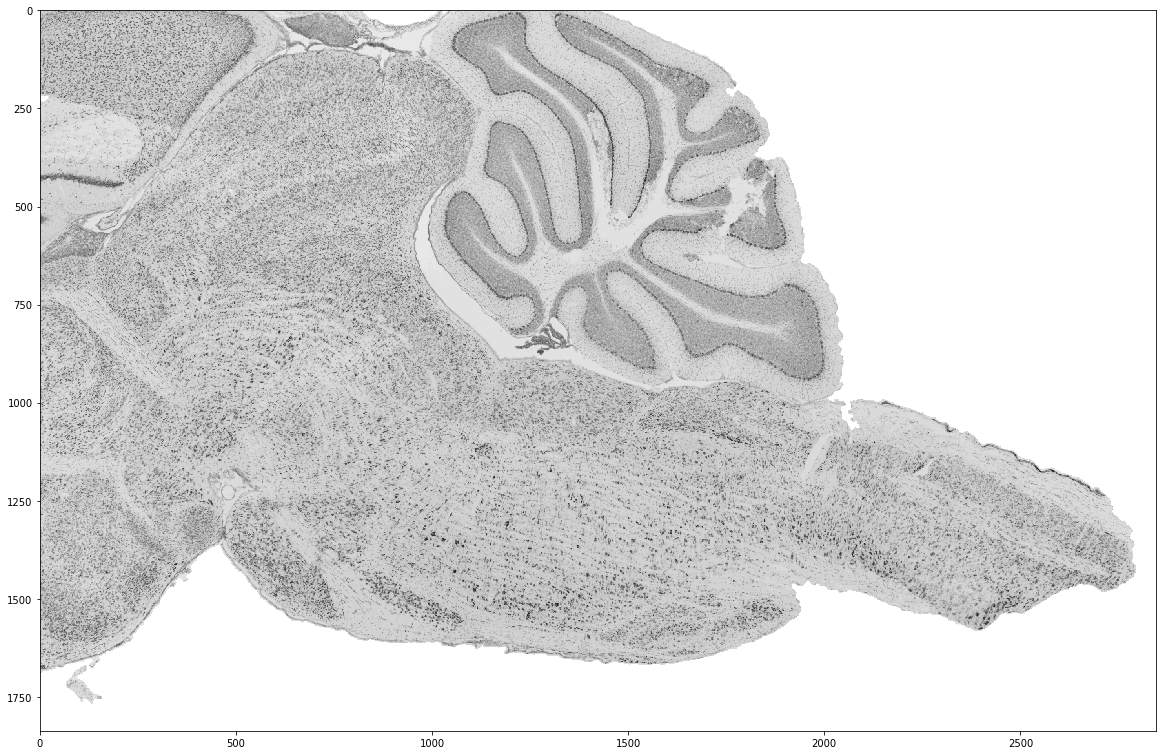

In [27]:
plt.figure(figsize=(20,20));
plt.imshow(img[::10, ::10], plt.cm.gray);

In [23]:
viz = DataManager.load_scoremap_viz_v2(stack='CHATM2', out_resolution='10.0um', 
                                       detector_id=799, prep_id=2, section=201, structure='6N')

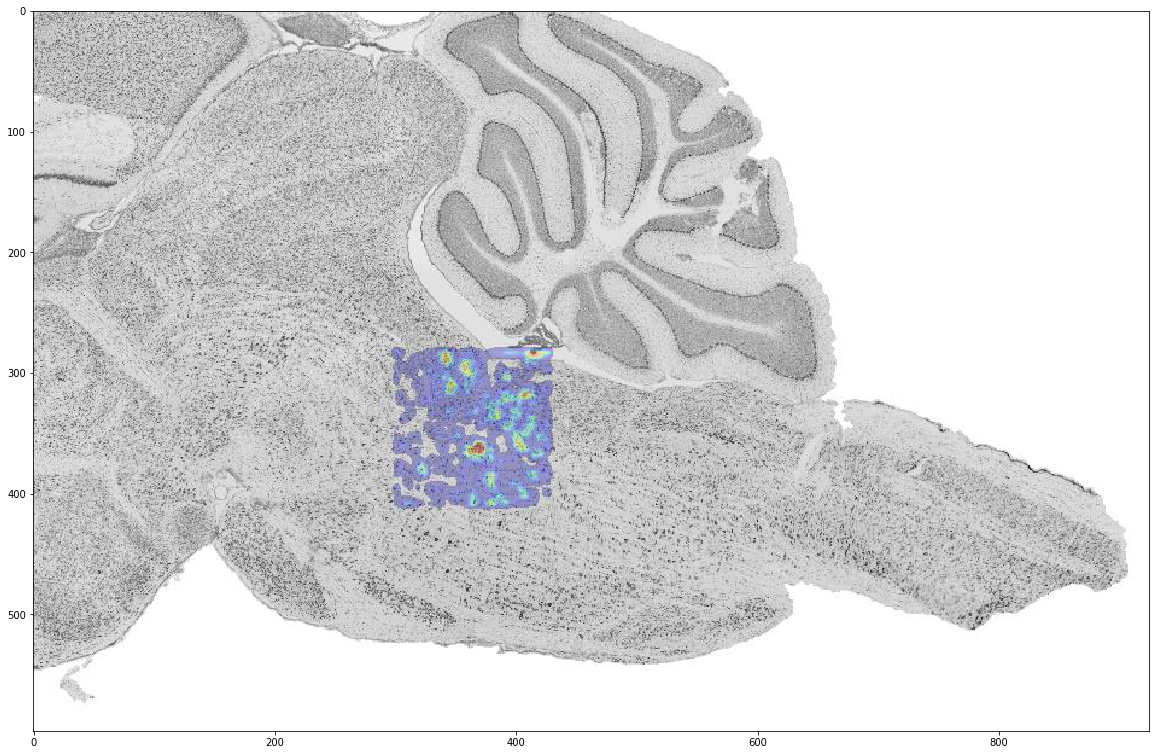

In [24]:
plt.figure(figsize=(20,20));
plt.imshow(viz);